In [2]:
# load packages
library(lubridate)
library(rlang)
library(tidyverse)


#### ----------------------------------------------------------------- Start Functions ****************************************************

## remove leading/trailing white space, convert blank cells to NA, convert POSIX object to Date, and convert from character to numeric where appropriate
Clean_Data_fx <- function(df1){
  ## Convert blanks to NA. Need to do this outside of dtplyr to recover type
  df1 <- map_df(df1, function(x){
    # Everything will be convert to character type. Capture the type to later convert back
    Type_use <- switch(match(typeof(x), c("logical", "integer", "double", "character")),
                       as.logical,
                       as.integer,
                       as.double,
                       as.character)
    
    Convert <- map_lgl(class(x), function(y){
      y %in% c("POSIXct", "POSIXt", "Date")
    })
    
    if(any(Convert)){
      return(as.Date(x))
      
    }else if(typeof(x) == "character"){
      return(tryCatch(type.convert(Type_use(gsub("^$", NA, trimws(x))), as.is = TRUE), error = function(e) x))
      
    }else{
      return(tryCatch(type.convert(Type_use(gsub("^$", NA, x)), as.is = TRUE), error = function(e) x))
    }
    
  })
  
  df1 <- df1 %>% mutate(across(where(is.factor), ~ as.character(.x)))
  
  return(df1)
  
}





#### ----------------------------------------------------------------- End Functions ****************************************************




###--------------------------------- Start Get Eligible Population ----------------------------------------------

## 3 months from end of August. Used to determine eligible members and checking and savings accounts
Startdate <- as.Date("2023-06-01", origin = "1970-01-01")


## Start with customer data to determine elgibility then look at account data
df_Cust <- readRDS('/anvil/projects/tdm//corporate/3rivers-membership/data/Customer_Table.rds')

## active member from at least June 1st 2023 and is currently active the customer type is "Personal" and the member is at least 18 years old
ID_use <- df_Cust %>%
  Clean_Data_fx(.) %>%          ## this is a self-written function to clean the data
  filter(datejoined < Startdate,
         isactive == "Yes",
         type == "Personal",
         age >= 18) %>%
  pull(id)
  
## read in customer to account table
df_CtA <- readRDS('/anvil/projects/tdm//corporate/3rivers-membership/data/CustomerToAccount_Table.rds')

## member needs to have an active checking or savings account that was opened before June 1st. 
# Doesn't matter if they are the primary on the account. Use the customer to account table because the account table will only have primary member
df_Population <- df_CtA %>%
  filter(application %in% c("CH", "SV")) %>%
  Clean_Data_fx(.) %>%                          ## this is a self-written function to clean the data
  filter(customerid %in% ID_use,
         startdatetime < Startdate,
         isactive == "Yes") %>%
  mutate(accountid = as.character(accountid)) ## make account id a string instead of a number


## read in account table. Need the  product market field
df_Acct <- readRDS('/anvil/projects/tdm//corporate/3rivers-membership/data/Account_Table.rds')

## last step is to check whether any of the checking or saving accounts are "Consumer". If not then drop 
df_Population  <- df_Acct %>%
  select(number, productmarket, productname) %>%
  left_join(df_Population, ., by = c("accountid" = "number")) %>%
  filter(is.na(productmarket == "Consumer") | productmarket == "Consumer",  ## some productmarket labels are missing which would count as "Consumer"
         productname != "Business Money Market") %>%                        #  except "Business Money Market"                     
  distinct(customerid)   ## only want unique customer id. 
  
  ## Need Secondary_ID to identify other memberships of the member. We will want to use that data for the member
df_Population <- df_Cust %>%
  select(customerid = id, Secondary_ID) %>%
  filter(customerid %in% df_Population$customerid) %>%
  mutate(Secondary_ID = ifelse(is.na(Secondary_ID), customerid, Secondary_ID)) ## assigned customerid when secondary is missing to filter when merging

#saveRDS(df_Population, file.path(myPaths$output, "Eligible_Members.rds"))
write.csv(df_Population, file ='/anvil/projects/tdm//corporate/3rivers-membership/projects/x-aselvitella/Eligible_Members.csv')


###--------------------------------- End Get Eligible Population ----------------------------------------------


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr   1.1.4     v readr   2.1.5
v forcats 1.0.0     v stringr 1.5.1
v ggplot2 3.5.0     v tibble  3.2.1
v purrr   1.0.2     v tidyr   1.3.1
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x purrr::%@%()         masks rlang::%@%()
x dplyr::filter()      masks stats::filter()
x purrr::flatten()     masks rlang::flatten()
x purrr::flatten_chr() masks rlang::flatten_chr()
x purrr::flatten_dbl() masks rlang::flatten_dbl()
x purrr::flatten_int() masks rlang::flatten_int()
x purrr::flatten_lgl() masks rlang::flatten_lgl()
x purrr::flatten_raw() masks rlang::flatten_raw()
x purrr::invoke()      masks rlang::invoke()
x dplyr::lag()         masks stats::lag()
x purrr::splice()      masks rlang::splice()
i Use the conflicted package (<http://conflicted.r-l

In [3]:
I5=intersect(df_Cust['id'][,1], df_Population['customerid'][,1])

In [4]:
length(I5)

[1] 127217

In [5]:
row_index5<-c()
for (j in 1:length(I5)) {
row_index5<-c(row_index5,which(df_Cust['id'] == I5[j]))
}
row_index5<-unique(row_index5)

head(row_index5)

[1] 166 169 171 172 173 174

In [5]:
df_Cust_5<-df_Cust[row_index5,]
dim(df_Cust_5)
head(df_Cust_5)

[1] 127217     60

,id,age,ageatjoining,autoloansprincipalbalance,cdaccountbalance,checkingaccountbalance,closestbranchdistance,currentcreditscore,creditscoregroup,datejoined,...,type,Online_user_status,Online_user_type,Online_user_create_dt,Online_last_login_dt,Online_last_app_login_dt,censuscode,HH_Number,RFG_Consumer_Segmint,Secondary_ID
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dttm>,...,<chr>,<chr>,<chr>,<date>,<date>,<date>,<chr>,<int>,<chr>,<chr>
166,P15225,65,34,0.00,0.0,4501.40,0.8,785,Very Good,1992-02-13,...,Personal,Active,Retail,2021-09-15,2023-08-30,2023-01-26,KZH8716593,851940,Credit Driven (ConSeg),PWTX218573904
169,P15256,64,32,0.00,0.0,1830.08,671.0,823,Excellent,1992-02-21,...,Personal,NA,NA,NA,NA,NA,WEH9207846,42211,Upscale (ConSeg),KCVN263985417
171,P15293,62,30,14642.51,0.0,350.73,1.8,735,Good,1992-02-28,...,Personal,Active,Retail,2021-09-15,2023-08-31,2023-08-31,RXI1527049,210778,Fee Driven (ConSeg),GQMC057948123
172,P15322,73,42,0.00,0.0,0.00,51.5,813,Excellent,1992-03-04,...,Personal,NA,NA,NA,NA,NA,USP9031845,NA,NA,CUGW096275483
173,P15325,73,41,0.00,0.0,7526.30,1.5,850,Excellent,1992-03-05,...,Personal,NA,NA,NA,NA,NA,BLY4053298,16616,Upscale (ConSeg),ZXCW164297035
174,P15326,51,20,1042.48,317046.3,69161.98,1.6,833,Excellent,1992-03-05,...,Personal,Active,Retail,2021-09-15,2023-08-31,2023-08-31,QCW9405316,3170,Middle Market (ConSeg),ZGQE495102673


In [6]:
summary(df_Cust_5)

      id                 age           ageatjoining    
 Length:127217      Min.   :  18.00   Min.   :-743.00  
 Class :character   1st Qu.:  33.00   1st Qu.:  22.00  
 Mode  :character   Median :  47.00   Median :  33.00  
                    Mean   :  47.97   Mean   :  34.49  
                    3rd Qu.:  61.00   3rd Qu.:  46.00  
                    Max.   :1041.00   Max.   :1036.00  
                                                       
 autoloansprincipalbalance cdaccountbalance  checkingaccountbalance
 Min.   :      0           Min.   :      0   Min.   :  -9505       
 1st Qu.:      0           1st Qu.:      0   1st Qu.:      0       
 Median :      0           Median :      0   Median :    286       
 Mean   :   3397           Mean   :   4521   Mean   :   7174       
 3rd Qu.:      0           3rd Qu.:      0   3rd Qu.:   2651       
 Max.   :1644706           Max.   :3856641   Max.   :4460744       
                                                                   
 closest

In [7]:
head(df_Cust_5)

,id,age,ageatjoining,autoloansprincipalbalance,cdaccountbalance,checkingaccountbalance,closestbranchdistance,currentcreditscore,creditscoregroup,datejoined,...,type,Online_user_status,Online_user_type,Online_user_create_dt,Online_last_login_dt,Online_last_app_login_dt,censuscode,HH_Number,RFG_Consumer_Segmint,Secondary_ID
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dttm>,...,<chr>,<chr>,<chr>,<date>,<date>,<date>,<chr>,<int>,<chr>,<chr>
166,P15225,65,34,0.00,0.0,4501.40,0.8,785,Very Good,1992-02-13,...,Personal,Active,Retail,2021-09-15,2023-08-30,2023-01-26,KZH8716593,851940,Credit Driven (ConSeg),PWTX218573904
169,P15256,64,32,0.00,0.0,1830.08,671.0,823,Excellent,1992-02-21,...,Personal,NA,NA,NA,NA,NA,WEH9207846,42211,Upscale (ConSeg),KCVN263985417
171,P15293,62,30,14642.51,0.0,350.73,1.8,735,Good,1992-02-28,...,Personal,Active,Retail,2021-09-15,2023-08-31,2023-08-31,RXI1527049,210778,Fee Driven (ConSeg),GQMC057948123
172,P15322,73,42,0.00,0.0,0.00,51.5,813,Excellent,1992-03-04,...,Personal,NA,NA,NA,NA,NA,USP9031845,NA,NA,CUGW096275483
173,P15325,73,41,0.00,0.0,7526.30,1.5,850,Excellent,1992-03-05,...,Personal,NA,NA,NA,NA,NA,BLY4053298,16616,Upscale (ConSeg),ZXCW164297035
174,P15326,51,20,1042.48,317046.3,69161.98,1.6,833,Excellent,1992-03-05,...,Personal,Active,Retail,2021-09-15,2023-08-31,2023-08-31,QCW9405316,3170,Middle Market (ConSeg),ZGQE495102673


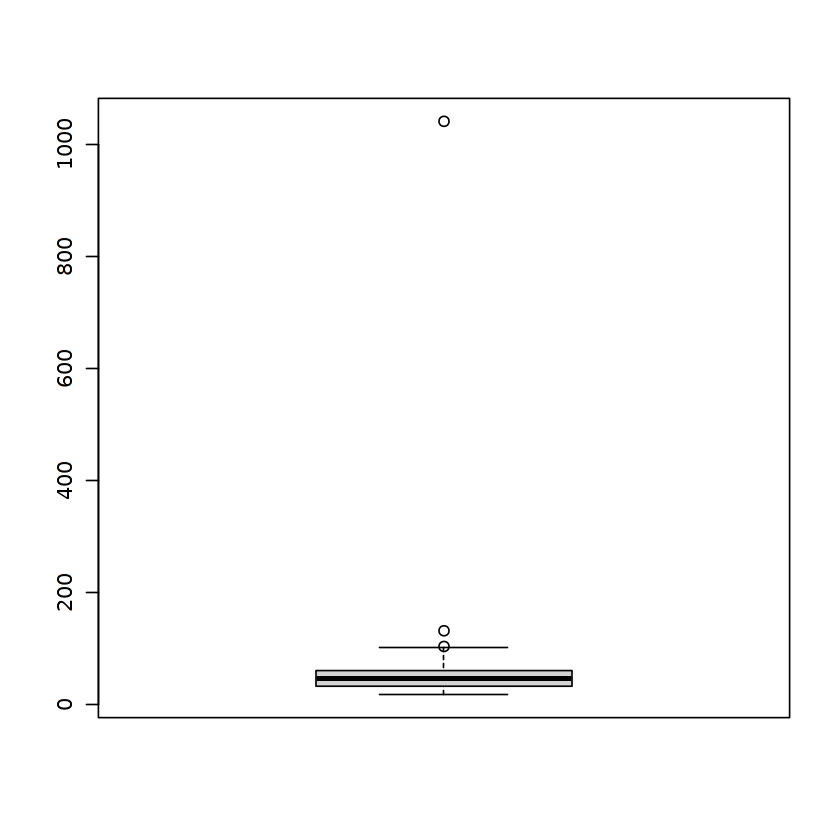

In [8]:
boxplot(df_Cust_5['age'])

In [9]:
which(df_Cust_5['age'][,1]>=105)

[1] 12255 40972

In [10]:
df_Cust_5[which(df_Cust_5['age'][,1]>=105),1]

[1] "P339957" "P236254"

In [11]:
df_Cust_5['age'][which(df_Cust_5['age'][,1]>=105),1]<-NA
df_Cust_5['age'][which(df_Cust_5['age'][,1]>=105),1]
which(df_Cust_5['age'][,1]>=105)

numeric(0)

integer(0)

In [12]:
summary(df_Cust_5['age'])

      age        
 Min.   : 18.00  
 1st Qu.: 33.00  
 Median : 47.00  
 Mean   : 47.96  
 3rd Qu.: 61.00  
 Max.   :104.00  
 NA's   :2       

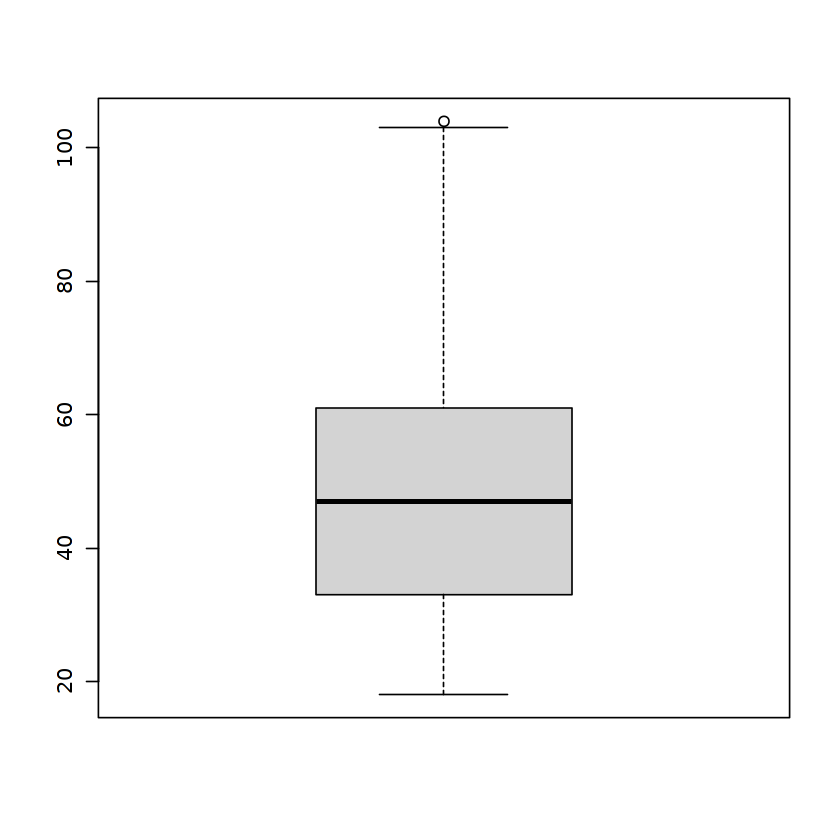

In [13]:
boxplot(df_Cust_5['age'])

In [14]:
summary(df_Cust_5['ageatjoining'])

  ageatjoining    
 Min.   :-743.00  
 1st Qu.:  22.00  
 Median :  33.00  
 Mean   :  34.49  
 3rd Qu.:  46.00  
 Max.   :1036.00  

In [15]:
which(df_Cust_5['ageatjoining'][,1]>=105)

[1] 12255 40972

In [16]:
df_Cust_5['ageatjoining'][which(df_Cust_5['ageatjoining'][,1]>=105),1]<-NA

In [17]:
df_Cust_5['age'][which(df_Cust_5['age'][,1]>=105),1]
which(df_Cust_5['age'][,1]>=105)

numeric(0)

integer(0)

In [18]:
summary(df_Cust_5['ageatjoining'])

  ageatjoining    
 Min.   :-743.00  
 1st Qu.:  22.00  
 Median :  33.00  
 Mean   :  34.48  
 3rd Qu.:  46.00  
 Max.   : 100.00  
 NA's   :2        

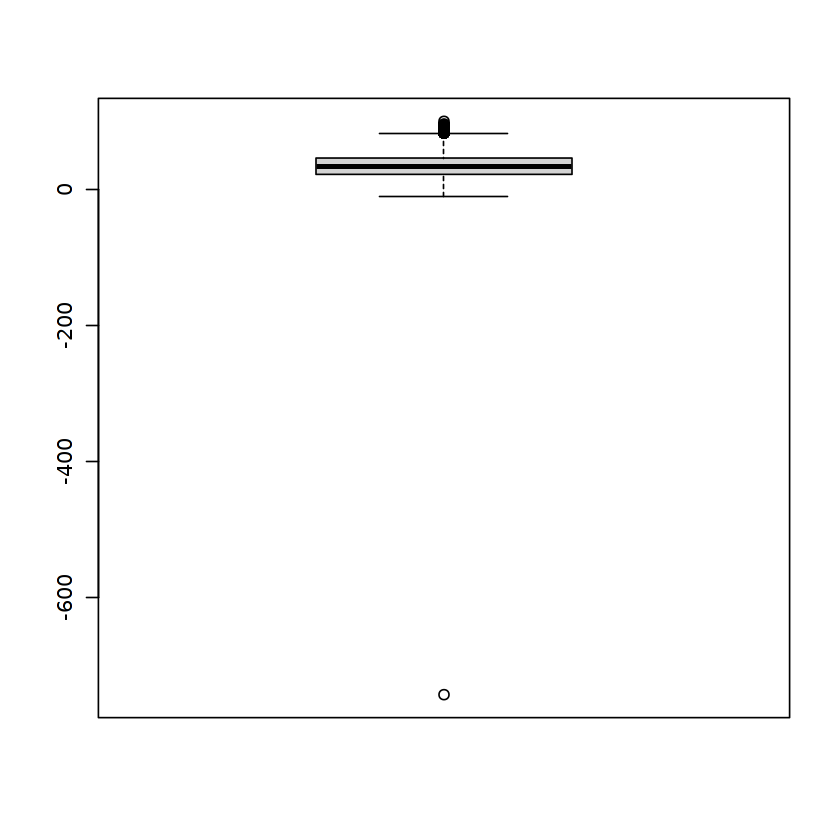

In [19]:
boxplot(df_Cust_5['ageatjoining'])

In [20]:
which(df_Cust_5['ageatjoining'][,1]<0)
#There might be other mistakes in the ageatjoining table

[1]  82676 100183 115687 122831 123193

In [21]:
df_Cust_5['ageatjoining'][which(df_Cust_5['ageatjoining'][,1]<0),1]<-NA
df_Cust_5['ageatjoining'][which(df_Cust_5['ageatjoining'][,1]<0),1]
which(df_Cust_5['ageatjoining'][,1]<0)

numeric(0)

integer(0)

In [22]:
summary(df_Cust_5['ageatjoining'])

  ageatjoining   
 Min.   :  0.00  
 1st Qu.: 22.00  
 Median : 33.00  
 Mean   : 34.49  
 3rd Qu.: 46.00  
 Max.   :100.00  
 NA's   :7       

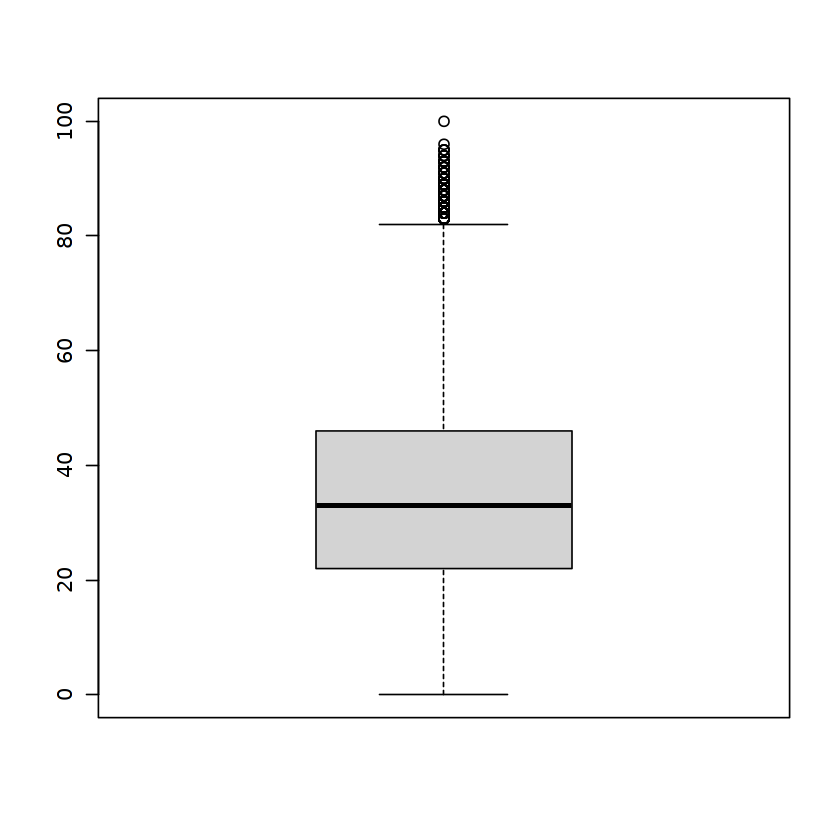

In [23]:
boxplot(df_Cust_5['ageatjoining'])

In [24]:
# need to ask John what "autoloansprincipalbalance" is and other variables as well

In [25]:
#Cluster Assignments
x<-df_Cust_5[c(2,3,4)]
head(x)
km.out <- kmeans(na.omit(x), 2, nstart = 20)

,age,ageatjoining,autoloansprincipalbalance
,<dbl>,<dbl>,<dbl>
166,65,34,0.00
169,64,32,0.00
171,62,30,14642.51
172,73,42,0.00
173,73,41,0.00
174,51,20,1042.48


In [26]:
km.out$cluster

166    169    171    172    173    174    175    176    177    178    184 
     1      1      1      1      1      1      1      1      2      1      1 
   186    192    196    197    198    199    203    206    208    209    211 
     1      1      1      2      1      2      1      1      1      1      1 
   217    218    219    220    223    224    225    226    227    228    229 
     1      1      1      1      1      1      1      1      2      1      1 
   231    233    235    237    238    239    241    242    243    249    250 
     1      2      1      1      1      1      1      1      1      1      1 
   252    254    255    256    258    259    262    302    303    305    308 
     1      1      1      1      1      1      1      1      1      1      1 
   312    314    315    317    320    321    322    323    327    331    332 
     1      1      1      1      1      1      1      1      1      1      1 
   333    336    337    338    341    342    345    350    352    354    356 
     1      1      1      1      1      1      1      1      1      1      1 
   357    359    360    361    362    363    364    366    368    371    373 
     1      1      1      1      1      1      1      1      1      1      1 
   374    375    376    378    379    427    429    430    431    432    434 
     1      1      1      1      1      1      1      1      1      1      1 
   435    438    440    442    443    444    445    446    447    449    452 
     1      1      1      1      1      1      1      1      1      1      1 
   454    455    461    467    468    471    472    474    475    476    478 
     1      1      1      1      1      1      1      1      1      1      1 
   480    482    484    487    488    492    495    497    499    500    538 
     1      1      1      1      1      1      2      1      1      1      1 
   539    541    545    548    550    551    552    553    554    556    560 
     1      1      2      1      1      1      1      1      1      1      1 
   561    565    572    573    575    579    580    581    582    583    584 
     1      1      1      1      1      1      1      1      1      1      2 
   585    587    589    591    597    598    599    602    604    606    609 
     1      1      1      1      1      1      1      1      1      1      1 
   611    613    614    618    619    621    622    667    669    671    676 
     1      1      1      1      1      1      1      1      1      1      1 
   682    683    686    687    690    695    696    701    702    707    708 
     1      2      1      1      1      1      2      1      1      1      1 
   710    713    715    717    718    723    725    726    728    732    738 
     2      1      1      1      1      1      1      1      1      1      1 
   742    743    746    747    748    752    754    755    760    761    763 
     1      1      1      1      1      1      1      1      1      2      1 
   764    765    811    813    814    816    817    819    820    821    823 
     1      1      1      1      1      1      1      1      2      1      1 
   825    828    829    834    835    844    845    847    848    849    852 
     1      1      1      1      1      1      2      1      1      2      1 
   857    858    860    863    865    867    868    870    872    873    874 
     1      1      2      1      1      1      1      1      1      1      1 
   875    876    878    879    880    882    884    885    891    892    894 
     1      1      1      1      1      1      1      1      1      1      1 
   895    902    904    905    906    946    948    952    953    955    956 
     1      1      1      1      1      1      1      1      1      1      1 
   958    960    961    967    969    970    971    972    974    976    978 
     1      1      1      1      1      1      1      1      1      1      1 
   979    981    982    983    985    987    991    993    995    997   1002 
     1      1      1     

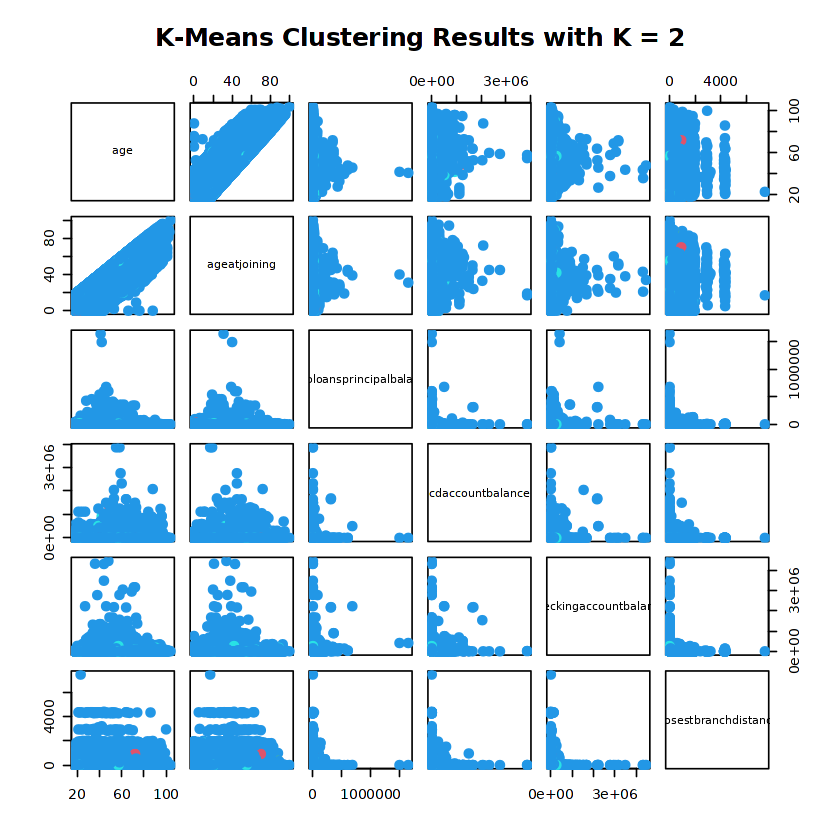

In [53]:
par(mfrow = c(1, 2))
plot(x, col = (km.out$cluster + 1),
main = "K-Means Clustering Results with K = 2", pch = 20, cex = 2)

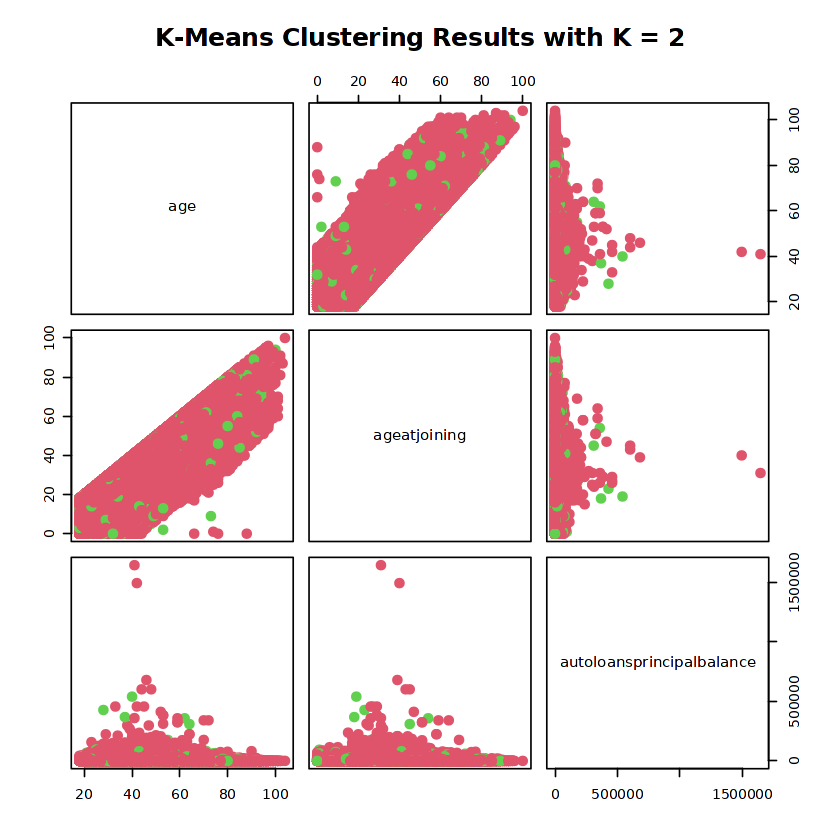

In [27]:
#Scale variables
xsc <- scale(x)
km.out_scaled <- kmeans(na.omit(xsc), 2, nstart = 20)
plot(x, col = (km.out$cluster + 1),
main = "K-Means Clustering Results with K = 2", pch = 20, cex = 2)